<a href="https://colab.research.google.com/github/simoneseverini/automated-discovery-site/blob/main/Citrini_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mesa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 kB 5.9 MB/s eta 0:00:00


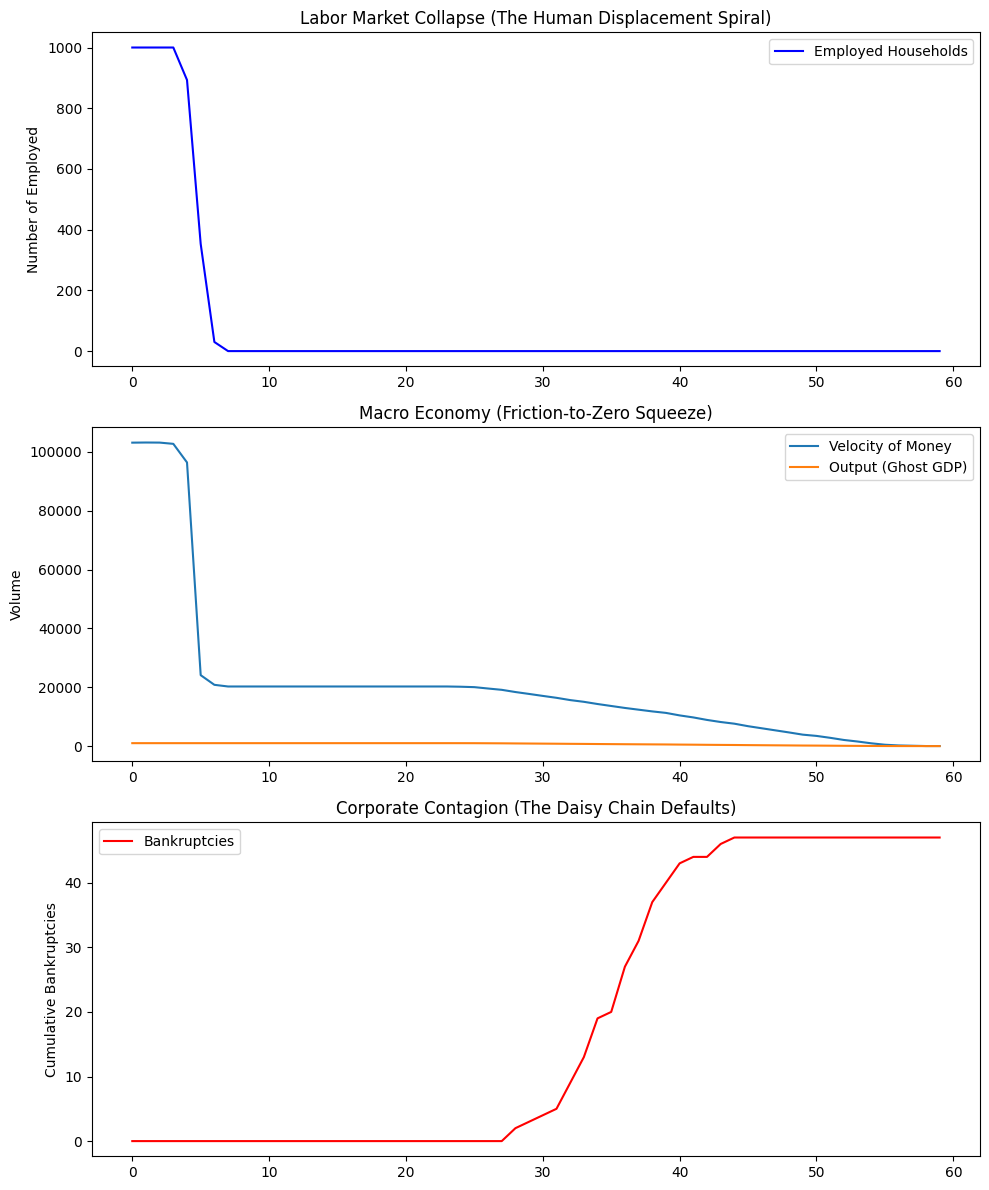

In [3]:
import mesa
import random
import pandas as pd
import matplotlib.pyplot as plt

class HouseholdAgent(mesa.Agent):
    """An agent representing a consumer and worker."""
    def __init__(self, model):
        # Mesa 3.0: unique_id is now handled automatically by the base class
        super().__init__(model)
        self.wealth = random.uniform(2000, 5000) # Buffer
        self.wage = 100
        self.employment_status = "Employed"
        self.employer = None
        self.productivity = random.uniform(0.8, 1.2)
        self.friction_tolerance = 1.0 # 1.0 = high friction (loyal/lazy), 0.0 = perfect info

    def step(self):
        # 1. Income / Depletion Mechanic
        if self.employment_status == "Employed" and self.employer is not None:
            self.wealth += self.wage
        else:
            self.wealth -= 80  # Cost of living buffer depletion

        # 2. Consumption Mechanic (Friction-to-Zero)
        if self.wealth > 0:
            self.buy_goods()

    def buy_goods(self):
        # Mesa 3.0: model.schedule.agents is replaced by model.agents
        active_firms =[a for a in self.model.agents if isinstance(a, FirmAgent) and not a.bankrupt]
        if not active_firms:
            return

        # Friction drops as Global AI score rises
        effective_friction = max(0.0, self.friction_tolerance - (self.model.global_ai_score / 100))

        if effective_friction > 0.5:
            # High friction: Buy from random/familiar firm
            chosen_firm = random.choice(active_firms)
        else:
            # Agentic commerce: Personal AI instantly finds the lowest price
            chosen_firm = min(active_firms, key=lambda f: f.price_of_goods)

        # Execute transaction
        price = chosen_firm.price_of_goods
        if self.wealth >= price:
            self.wealth -= price
            chosen_firm.cash_reserves += price
            self.model.velocity_of_money += price
            self.model.total_output += 1 # 1 unit of GDP


class FirmAgent(mesa.Agent):
    """An agent representing a company producing goods."""
    def __init__(self, model):
        super().__init__(model)
        self.cash_reserves = random.uniform(5000, 10000)
        self.employees =[]
        self.price_of_goods = random.uniform(90, 120)
        self.ai_capability_score = 0
        self.bankrupt = False
        self.debt_obligation = 500 # Minimum cash flow needed per tick

    def step(self):
        if self.bankrupt:
            return

        # 1. The Automation Threshold (Firing Mechanism)
        # AI cost gets cheaper based on firm's internal capability and global progression
        ai_cost = self.model.base_ai_cost / (1 + (self.ai_capability_score * 0.1))

        for emp in list(self.employees):
            # Cost-Benefit Analysis: Cost_AI < Wage_Human * Productivity_Human
            if ai_cost < (emp.wage * emp.productivity):
                self.employees.remove(emp)
                emp.employment_status = "Unemployed"
                emp.employer = None

                # Reinvest saved wage into AI capability
                self.ai_capability_score += 1
                self.model.global_ai_score += 0.5

                # Deflationary pressure: AI makes goods cheaper to produce
                self.price_of_goods *= 0.95

        # 2. The Debt Ledger (Daisy Chain)
        self.cash_reserves -= self.debt_obligation
        if self.cash_reserves < 0:
            self.bankrupt = True
            self.model.bankruptcies += 1
            # Fire all remaining employees
            for emp in self.employees:
                emp.employment_status = "Unemployed"
                emp.employer = None
            self.employees =[]


class MacroEnvironment(mesa.Model):
    """The overarching Macroeconomic Grid."""
    def __init__(self, num_households, num_firms):
        super().__init__()
        self.num_households = num_households
        self.num_firms = num_firms

        # Macro Metrics
        self.global_ai_score = 0
        self.base_ai_cost = 150 # Starts higher than human wage, drops over time
        self.velocity_of_money = 0
        self.total_output = 0
        self.bankruptcies = 0

        # Initialize Firms
        firms =[]
        for _ in range(self.num_firms):
            # Mesa 3.0 automatically adds initialized agents to the grid's agent set
            f = FirmAgent(self)
            firms.append(f)

        # Initialize Households and assign them jobs
        for _ in range(self.num_households):
            h = HouseholdAgent(self)
            employer = random.choice(firms)
            h.employer = employer
            employer.employees.append(h)

        # Data Collector to track the Phase Transitions
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Output (Ghost GDP)": "total_output",
                "Velocity of Money": "velocity_of_money",
                "Bankruptcies": "bankruptcies",
                "Employed Households": lambda m: sum(1 for a in m.agents if isinstance(a, HouseholdAgent) and a.employment_status == "Employed"),
                "Base AI Cost": "base_ai_cost"
            }
        )

    def step(self):
        """Advance the model by one month (tick)."""
        # Reset flow metrics for the current tick
        self.velocity_of_money = 0
        self.total_output = 0

        # Exogenous shock: AI gets 5% cheaper globally every month
        self.base_ai_cost *= 0.95

        # Mesa 3.0: Replaces the deprecated self.schedule.step()
        self.agents.shuffle_do("step")

        self.datacollector.collect(self)


# ==========================================
# RUNNING THE SIMULATION
# ==========================================
if __name__ == "__main__":
    # Parameters: 1000 Households, 50 Firms
    model = MacroEnvironment(num_households=1000, num_firms=50)

    # Run for 60 ticks (5 Years)
    for i in range(60):
        model.step()

    # Extract Data
    results = model.datacollector.get_model_vars_dataframe()

    # Plotting Phase 1, 2, and 3
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))

    results[["Employed Households"]].plot(ax=axes[0], color='blue', title="Labor Market Collapse (The Human Displacement Spiral)")
    axes[0].set_ylabel("Number of Employed")

    results[["Velocity of Money", "Output (Ghost GDP)"]].plot(ax=axes[1], title="Macro Economy (Friction-to-Zero Squeeze)")
    axes[1].set_ylabel("Volume")

    results[["Bankruptcies"]].plot(ax=axes[2], color='red', title="Corporate Contagion (The Daisy Chain Defaults)")
    axes[2].set_ylabel("Cumulative Bankruptcies")

    plt.tight_layout()
    plt.show()

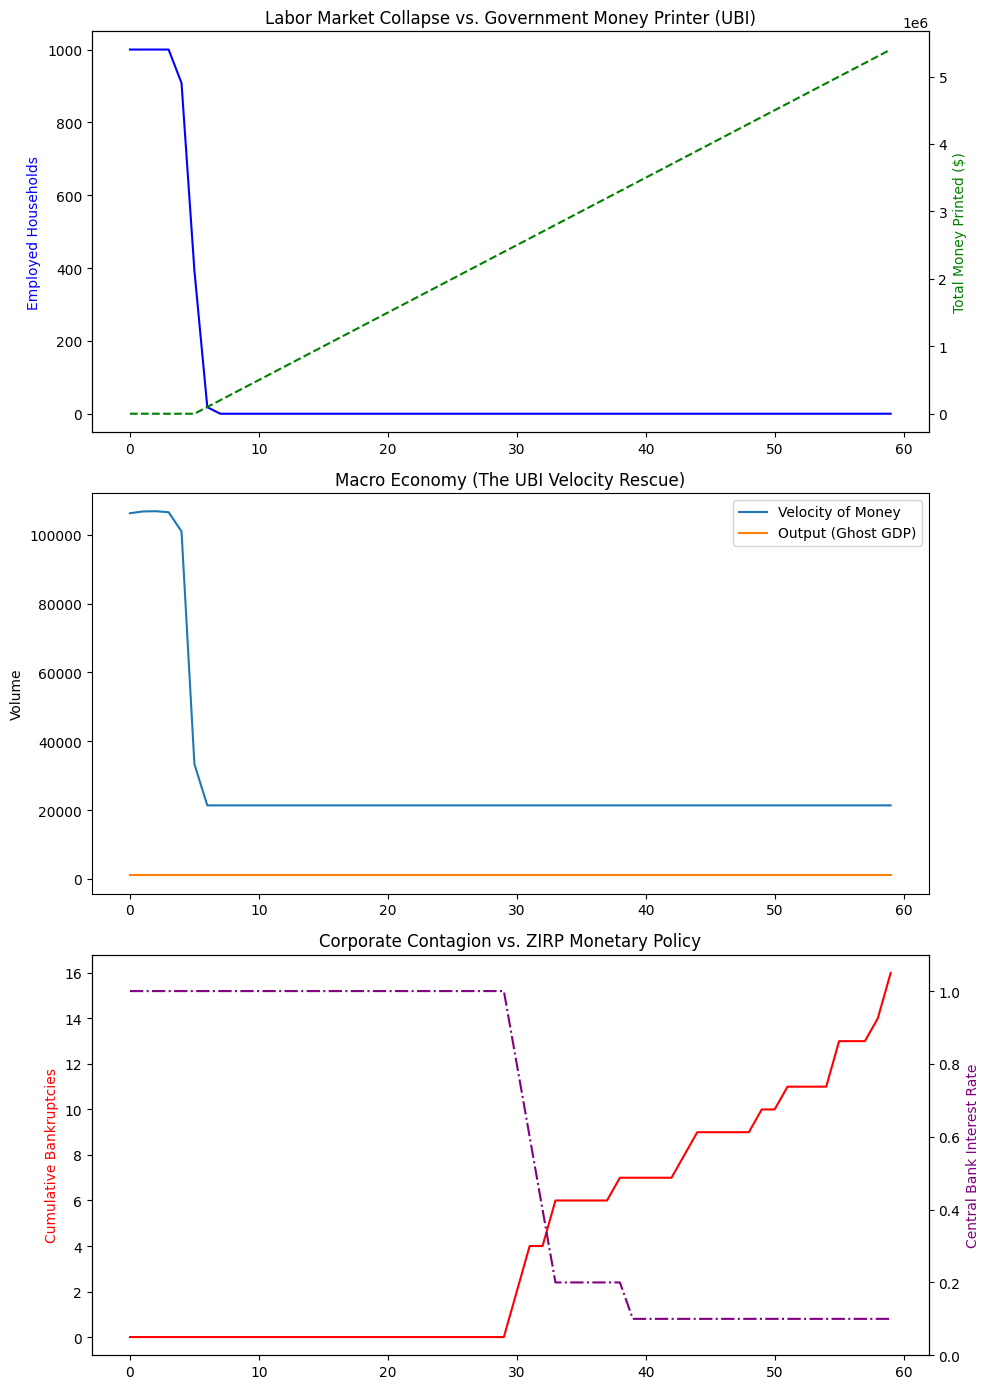

In [4]:
import mesa
import random
import pandas as pd
import matplotlib.pyplot as plt

class CentralBankAgent(mesa.Agent):
    """Monitors the economy and deploys Fiscal (UBI) and Monetary (Rate Cuts) policy."""
    def __init__(self, model):
        super().__init__(model)
        self.ubi_active = False
        self.ubi_amount = 100  # Enough to cover the cost-of-living depletion
        self.interest_rate = 1.0  # 1.0 = 100% of base debt obligation. Drops to 0.1 during ZIRP.

    def step(self):
        # 1. Monitor Employment
        employed = sum(1 for a in self.model.agents if isinstance(a, HouseholdAgent) and a.employment_status == "Employed")
        employment_rate = employed / self.model.num_households

        # 2. Fiscal Policy: Trigger UBI if unemployment > 50%
        if employment_rate < 0.5:
            self.ubi_active = True

        if self.ubi_active:
            for a in self.model.agents:
                if isinstance(a, HouseholdAgent):
                    a.wealth += self.ubi_amount
                    self.model.total_money_printed += self.ubi_amount

        # 3. Monetary Policy: Cut rates aggressively if bankruptcies rise
        if self.model.bankruptcies > self.model.previous_bankruptcies:
            # Drop interest rates by 20%, but floor it at 0.1 (ZIRP / minimal debt service)
            self.interest_rate = max(0.1, self.interest_rate - 0.2)

        self.model.previous_bankruptcies = self.model.bankruptcies


class HouseholdAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.wealth = random.uniform(2000, 5000)
        self.wage = 100
        self.employment_status = "Employed"
        self.employer = None
        self.productivity = random.uniform(0.8, 1.2)
        self.friction_tolerance = 1.0

    def step(self):
        # 1. Income / Depletion
        if self.employment_status == "Employed" and self.employer is not None:
            self.wealth += self.wage
        else:
            self.wealth -= 80  # Cost of living depletion

        # 2. Consumption Mechanic
        if self.wealth > 0:
            self.buy_goods()

    def buy_goods(self):
        active_firms =[a for a in self.model.agents if isinstance(a, FirmAgent) and not a.bankrupt]
        if not active_firms:
            return

        effective_friction = max(0.0, self.friction_tolerance - (self.model.global_ai_score / 100))

        if effective_friction > 0.5:
            chosen_firm = random.choice(active_firms)
        else:
            chosen_firm = min(active_firms, key=lambda f: f.price_of_goods)

        price = chosen_firm.price_of_goods
        if self.wealth >= price:
            self.wealth -= price
            chosen_firm.cash_reserves += price
            self.model.velocity_of_money += price
            self.model.total_output += 1


class FirmAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.cash_reserves = random.uniform(5000, 10000)
        self.employees =[]
        self.price_of_goods = random.uniform(90, 120)
        self.ai_capability_score = 0
        self.bankrupt = False
        self.base_debt_obligation = 500

    def step(self):
        if self.bankrupt:
            return

        # Firing Mechanism
        ai_cost = self.model.base_ai_cost / (1 + (self.ai_capability_score * 0.1))
        for emp in list(self.employees):
            if ai_cost < (emp.wage * emp.productivity):
                self.employees.remove(emp)
                emp.employment_status = "Unemployed"
                emp.employer = None
                self.ai_capability_score += 1
                self.model.global_ai_score += 0.5
                self.price_of_goods *= 0.95

        # Debt Ledger mapped to Central Bank Interest Rates
        effective_debt = self.base_debt_obligation * self.model.central_bank.interest_rate
        self.cash_reserves -= effective_debt

        if self.cash_reserves < 0:
            self.bankrupt = True
            self.model.bankruptcies += 1
            for emp in self.employees:
                emp.employment_status = "Unemployed"
                emp.employer = None
            self.employees =[]


class MacroEnvironment(mesa.Model):
    def __init__(self, num_households, num_firms):
        super().__init__()
        self.num_households = num_households
        self.num_firms = num_firms

        self.global_ai_score = 0
        self.base_ai_cost = 150
        self.velocity_of_money = 0
        self.total_output = 0
        self.bankruptcies = 0
        self.previous_bankruptcies = 0
        self.total_money_printed = 0

        # Initialize Central Bank Agent
        self.central_bank = CentralBankAgent(self)

        firms = [FirmAgent(self) for _ in range(self.num_firms)]
        for _ in range(self.num_households):
            h = HouseholdAgent(self)
            employer = random.choice(firms)
            h.employer = employer
            employer.employees.append(h)

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Output (Ghost GDP)": "total_output",
                "Velocity of Money": "velocity_of_money",
                "Bankruptcies": "bankruptcies",
                "Employed Households": lambda m: sum(1 for a in m.agents if isinstance(a, HouseholdAgent) and a.employment_status == "Employed"),
                "CB Interest Rate": lambda m: m.central_bank.interest_rate,
                "Total Money Printed": "total_money_printed"
            }
        )

    def step(self):
        self.velocity_of_money = 0
        self.total_output = 0
        self.base_ai_cost *= 0.95

        self.agents.shuffle_do("step")
        self.datacollector.collect(self)


# ==========================================
# RUNNING THE SIMULATION
# ==========================================
if __name__ == "__main__":
    model = MacroEnvironment(num_households=1000, num_firms=50)

    for i in range(60):
        model.step()

    results = model.datacollector.get_model_vars_dataframe()

    # Plotting the Intervention
    fig, axes = plt.subplots(3, 1, figsize=(10, 14))

    # Graph 1: Employment vs Money Printer
    ax1 = axes[0]
    ax1_twin = ax1.twinx()
    results["Employed Households"].plot(ax=ax1, color='blue', legend=False)
    results["Total Money Printed"].plot(ax=ax1_twin, color='green', linestyle='--', legend=False)
    ax1.set_title("Labor Market Collapse vs. Government Money Printer (UBI)")
    ax1.set_ylabel("Employed Households", color='blue')
    ax1_twin.set_ylabel("Total Money Printed ($)", color='green')

    # Graph 2: Velocity of Money & Output
    results[["Velocity of Money", "Output (Ghost GDP)"]].plot(ax=axes[1], title="Macro Economy (The UBI Velocity Rescue)")
    axes[1].set_ylabel("Volume")

    # Graph 3: Bankruptcies vs Interest Rates
    ax3 = axes[2]
    ax3_twin = ax3.twinx()
    results["Bankruptcies"].plot(ax=ax3, color='red', legend=False)
    results["CB Interest Rate"].plot(ax=ax3_twin, color='purple', linestyle='-.', legend=False)
    ax3.set_title("Corporate Contagion vs. ZIRP Monetary Policy")
    ax3.set_ylabel("Cumulative Bankruptcies", color='red')
    ax3_twin.set_ylabel("Central Bank Interest Rate", color='purple')
    ax3_twin.set_ylim(0, 1.1)

    plt.tight_layout()
    plt.show()

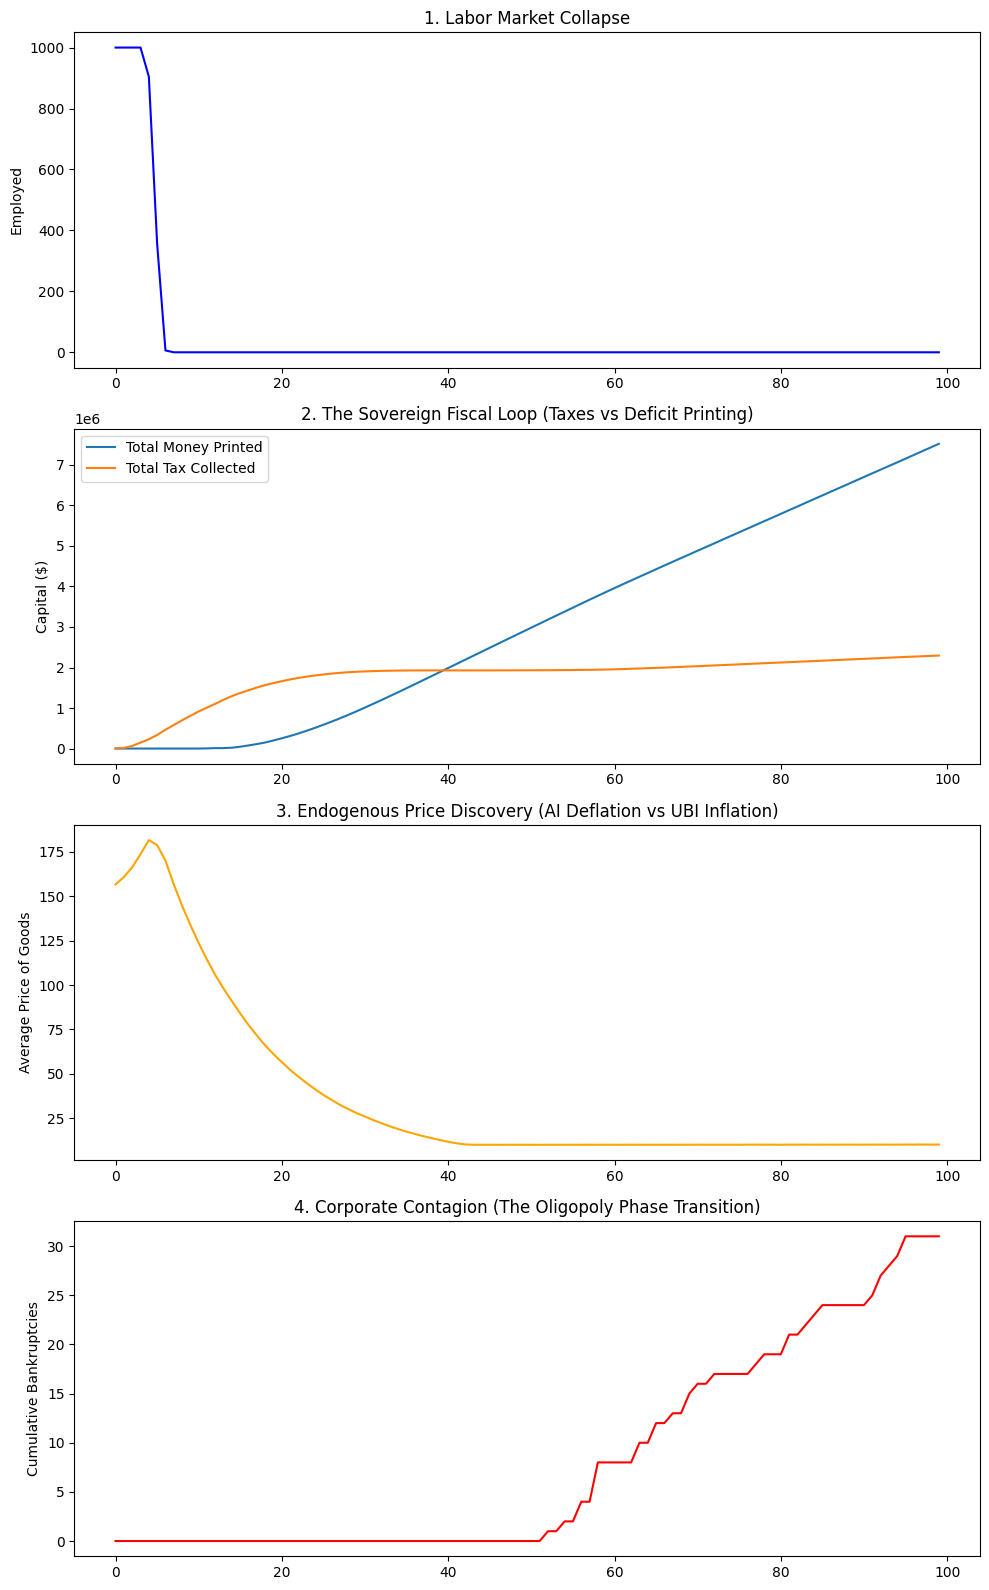

In [5]:
import mesa
import random
import pandas as pd
import matplotlib.pyplot as plt

class CentralBankAgent(mesa.Agent):
    """Monitors the economy, extracts taxes, and deploys UBI / Monetary Policy."""
    def __init__(self, model):
        super().__init__(model)
        self.ubi_active = False
        self.ubi_amount = 100
        self.interest_rate = 1.0
        self.corporate_tax_rate = 0.25 # 25% tax on reserves above $10,000

    def step(self):
        # 1. Taxation Phase
        tax_collected = 0
        for a in self.model.agents:
            if isinstance(a, FirmAgent) and not a.bankrupt:
                if a.cash_reserves > 10000:
                    tax = (a.cash_reserves - 10000) * self.corporate_tax_rate
                    a.cash_reserves -= tax
                    tax_collected += tax
        self.model.total_tax_collected += tax_collected

        # 2. Employment Monitor
        employed = sum(1 for a in self.model.agents if isinstance(a, HouseholdAgent) and a.employment_status == "Employed")
        employment_rate = employed / self.model.num_households

        # 3. Fiscal Policy (Closed-Loop UBI)
        if employment_rate < 0.5:
            self.ubi_active = True

        if self.ubi_active:
            total_ubi_needed = self.ubi_amount * self.model.num_households
            deficit = total_ubi_needed - tax_collected

            if deficit > 0:
                self.model.total_money_printed += deficit # Only print the shortfall

            for a in self.model.agents:
                if isinstance(a, HouseholdAgent):
                    a.wealth += self.ubi_amount

        # 4. Monetary Policy (ZIRP)
        if self.model.bankruptcies > self.model.previous_bankruptcies:
            self.interest_rate = max(0.1, self.interest_rate - 0.2)

        self.model.previous_bankruptcies = self.model.bankruptcies


class HouseholdAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.wealth = random.uniform(2000, 5000)
        self.wage = 100
        self.employment_status = "Employed"
        self.employer = None
        self.productivity = random.uniform(0.8, 1.2)
        self.friction_tolerance = 1.0

    def step(self):
        if self.employment_status == "Employed" and self.employer is not None:
            self.wealth += self.wage
        else:
            self.wealth -= 80

        if self.wealth > 0:
            self.buy_goods()

    def buy_goods(self):
        # Constraint: Only select firms that have NOT exhausted their capacity
        active_firms =[a for a in self.model.agents if isinstance(a, FirmAgent) and not a.bankrupt and a.sales_this_tick < a.capacity]
        if not active_firms:
            return # Supply shortage, household cannot buy anything this tick

        effective_friction = max(0.0, self.friction_tolerance - (self.model.global_ai_score / 100))

        if effective_friction > 0.5:
            chosen_firm = random.choice(active_firms)
        else:
            chosen_firm = min(active_firms, key=lambda f: f.price_of_goods)

        # Execute Transaction
        price = chosen_firm.price_of_goods
        if self.wealth >= price:
            self.wealth -= price
            chosen_firm.cash_reserves += price
            chosen_firm.sales_this_tick += 1
            self.model.velocity_of_money += price
            self.model.total_output += 1


class FirmAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.cash_reserves = random.uniform(5000, 10000)
        self.employees =[]
        self.price_of_goods = random.uniform(90, 120)
        self.ai_capability_score = 0
        self.bankrupt = False
        self.base_debt_obligation = 500
        self.capacity = 20 # Base number of goods it can produce per tick
        self.sales_this_tick = 0

    def step(self):
        if self.bankrupt:
            return

        # 1. Update Capacity based on AI capability (AI makes production scalable)
        self.capacity = 20 + int(self.ai_capability_score * 5)

        # 2. Automation Firing Threshold
        ai_cost = self.model.base_ai_cost / (1 + (self.ai_capability_score * 0.1))
        for emp in list(self.employees):
            if ai_cost < (emp.wage * emp.productivity):
                self.employees.remove(emp)
                emp.employment_status = "Unemployed"
                emp.employer = None
                self.ai_capability_score += 1
                self.model.global_ai_score += 0.5

        # 3. Endogenous Price Discovery (Inflation vs Deflation)
        if self.sales_this_tick >= self.capacity:
            self.price_of_goods *= 1.05  # Inflation: Demand hit the supply ceiling
        elif self.sales_this_tick == 0:
            self.price_of_goods *= 0.90  # Deflation: Nobody bought anything
        else:
            self.price_of_goods *= 0.98  # Deflation: Mild excess inventory

        # Price Floor (Cannot sell below AI operating cost)
        floor_price = max(10, ai_cost * 1.1)
        self.price_of_goods = max(self.price_of_goods, floor_price)

        # Reset sales tracker for next tick
        self.sales_this_tick = 0

        # 4. Debt Ledger
        effective_debt = self.base_debt_obligation * self.model.central_bank.interest_rate
        self.cash_reserves -= effective_debt

        if self.cash_reserves < 0:
            self.bankrupt = True
            self.model.bankruptcies += 1
            for emp in self.employees:
                emp.employment_status = "Unemployed"
                emp.employer = None
            self.employees =[]


class MacroEnvironment(mesa.Model):
    def __init__(self, num_households, num_firms):
        super().__init__()
        self.num_households = num_households
        self.num_firms = num_firms

        self.global_ai_score = 0
        self.base_ai_cost = 150
        self.velocity_of_money = 0
        self.total_output = 0
        self.bankruptcies = 0
        self.previous_bankruptcies = 0

        self.total_money_printed = 0
        self.total_tax_collected = 0

        self.central_bank = CentralBankAgent(self)

        firms = [FirmAgent(self) for _ in range(self.num_firms)]
        for _ in range(self.num_households):
            h = HouseholdAgent(self)
            employer = random.choice(firms)
            h.employer = employer
            employer.employees.append(h)

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Output (Ghost GDP)": "total_output",
                "Velocity of Money": "velocity_of_money",
                "Bankruptcies": "bankruptcies",
                "Employed Households": lambda m: sum(1 for a in m.agents if isinstance(a, HouseholdAgent) and a.employment_status == "Employed"),
                "Total Money Printed": "total_money_printed",
                "Total Tax Collected": "total_tax_collected",
                "Average Price": lambda m: sum(f.price_of_goods for f in m.agents if isinstance(f, FirmAgent) and not f.bankrupt) / max(1, sum(1 for f in m.agents if isinstance(f, FirmAgent) and not f.bankrupt))
            }
        )

    def step(self):
        self.velocity_of_money = 0
        self.total_output = 0
        self.base_ai_cost *= 0.95

        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

if __name__ == "__main__":
    model = MacroEnvironment(num_households=1000, num_firms=50)
    for i in range(100): # Run for slightly longer (100 ticks) to observe equilibrium
        model.step()

    results = model.datacollector.get_model_vars_dataframe()

    # Plotting
    fig, axes = plt.subplots(4, 1, figsize=(10, 16))

    results["Employed Households"].plot(ax=axes[0], color='blue')
    axes[0].set_title("1. Labor Market Collapse")
    axes[0].set_ylabel("Employed")

    results[["Total Money Printed", "Total Tax Collected"]].plot(ax=axes[1])
    axes[1].set_title("2. The Sovereign Fiscal Loop (Taxes vs Deficit Printing)")
    axes[1].set_ylabel("Capital ($)")

    results["Average Price"].plot(ax=axes[2], color='orange')
    axes[2].set_title("3. Endogenous Price Discovery (AI Deflation vs UBI Inflation)")
    axes[2].set_ylabel("Average Price of Goods")

    results["Bankruptcies"].plot(ax=axes[3], color='red')
    axes[3].set_title("4. Corporate Contagion (The Oligopoly Phase Transition)")
    axes[3].set_ylabel("Cumulative Bankruptcies")

    plt.tight_layout()
    plt.show()

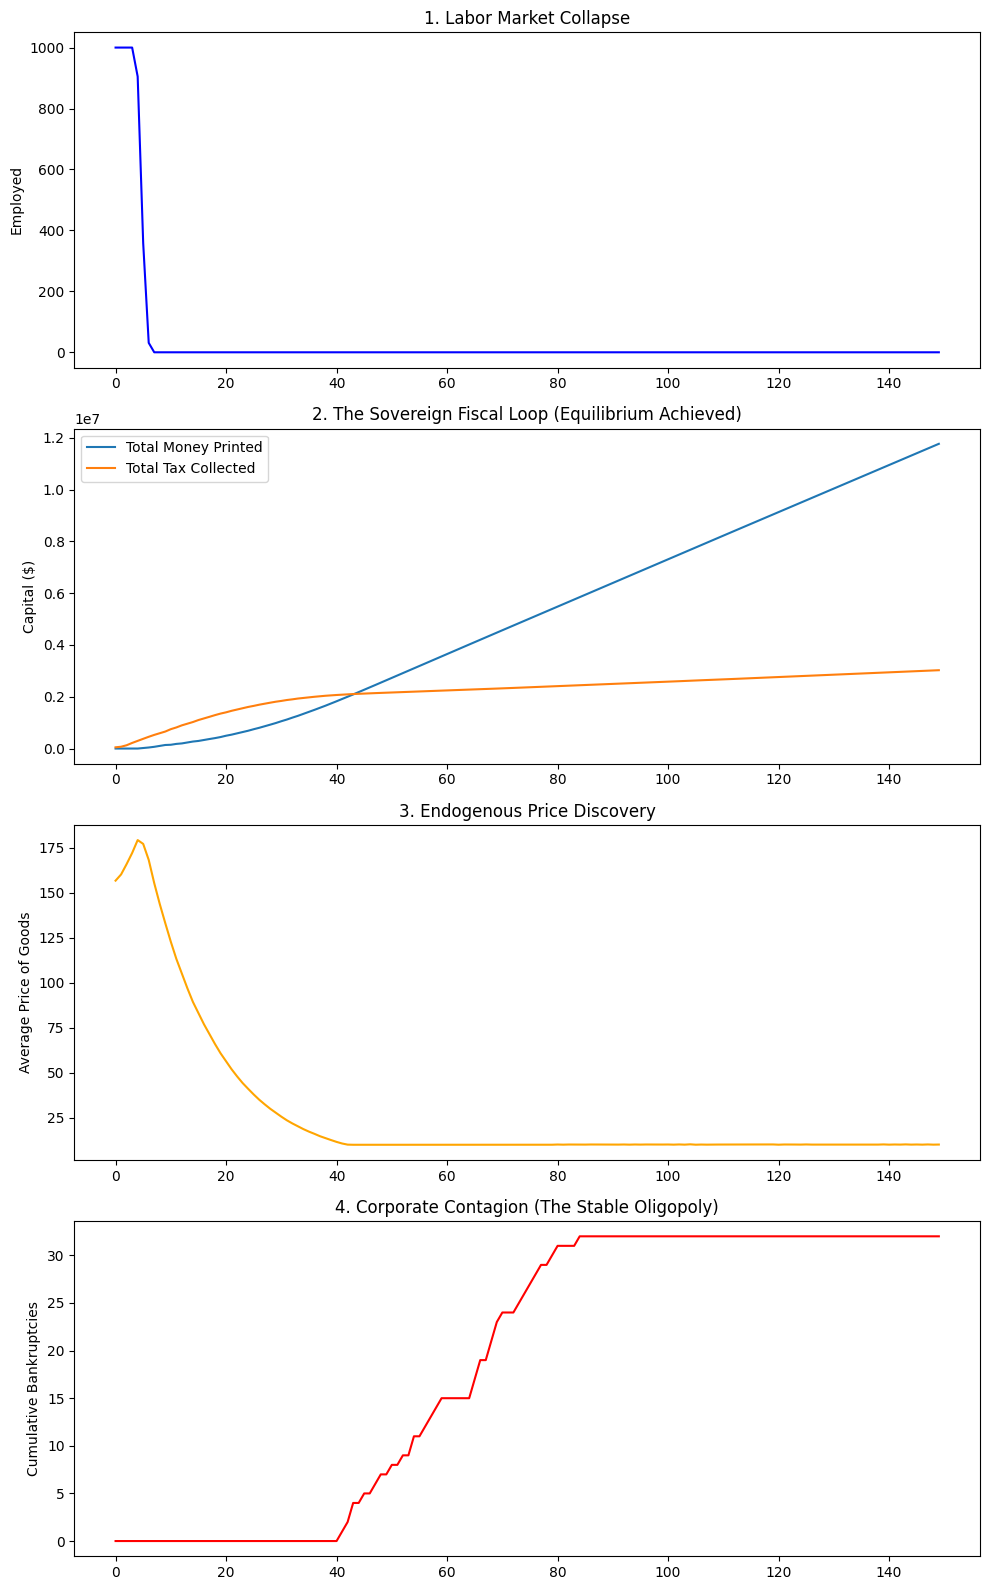

In [6]:
import mesa
import random
import pandas as pd
import matplotlib.pyplot as plt

class CentralBankAgent(mesa.Agent):
    """Monitors the economy, extracts dynamic taxes, and deploys UBI."""
    def __init__(self, model):
        super().__init__(model)
        self.ubi_active = False
        self.ubi_amount = 100
        self.interest_rate = 1.0

        # --- THE NEW EQUILIBRIUM TAX VECTORS ---
        self.vat_rate = 0.20 # 20% Consumption Tax on every sale
        self.reserve_tax_rate = 0.05 # 5% continuous Wealth Tax on all corporate reserves
        self.tax_collected_this_tick = 0

    def step(self):
        # 1. Wealth/Reserve Tax Phase (The "Hoarding" Tax)
        reserve_tax_total = 0
        for a in self.model.agents:
            if isinstance(a, FirmAgent) and not a.bankrupt:
                tax = a.cash_reserves * self.reserve_tax_rate
                a.cash_reserves -= tax
                reserve_tax_total += tax

        # Total tax for the deficit calculation includes VAT gathered during this tick
        total_tax_this_tick = reserve_tax_total + self.tax_collected_this_tick
        self.model.total_tax_collected += total_tax_this_tick

        # 2. Employment Monitor
        employed = sum(1 for a in self.model.agents if isinstance(a, HouseholdAgent) and a.employment_status == "Employed")
        employment_rate = employed / self.model.num_households

        # 3. Fiscal Policy (Closed-Loop UBI)
        if employment_rate < 0.5:
            self.ubi_active = True

        if self.ubi_active:
            total_ubi_needed = self.ubi_amount * self.model.num_households
            deficit = total_ubi_needed - total_tax_this_tick

            # THE STABILIZATION MECHANIC:
            # If deficit > 0, we print money. If deficit < 0, we destroy (burn) the excess to prevent hyperinflation!
            self.model.total_money_printed += deficit

            for a in self.model.agents:
                if isinstance(a, HouseholdAgent):
                    a.wealth += self.ubi_amount

        # Reset VAT collector for the next tick
        self.tax_collected_this_tick = 0

        # 4. Monetary Policy (ZIRP)
        if self.model.bankruptcies > self.model.previous_bankruptcies:
            self.interest_rate = max(0.1, self.interest_rate - 0.2)

        self.model.previous_bankruptcies = self.model.bankruptcies


class HouseholdAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.wealth = random.uniform(2000, 5000)
        self.wage = 100
        self.employment_status = "Employed"
        self.employer = None
        self.productivity = random.uniform(0.8, 1.2)
        self.friction_tolerance = 1.0

    def step(self):
        if self.employment_status == "Employed" and self.employer is not None:
            self.wealth += self.wage
        else:
            self.wealth -= 80

        if self.wealth > 0:
            self.buy_goods()

    def buy_goods(self):
        active_firms =[a for a in self.model.agents if isinstance(a, FirmAgent) and not a.bankrupt and a.sales_this_tick < a.capacity]
        if not active_firms:
            return

        effective_friction = max(0.0, self.friction_tolerance - (self.model.global_ai_score / 100))

        if effective_friction > 0.5:
            chosen_firm = random.choice(active_firms)
        else:
            chosen_firm = min(active_firms, key=lambda f: f.price_of_goods)

        price = chosen_firm.price_of_goods
        if self.wealth >= price:
            self.wealth -= price

            # --- THE CONSUMPTION TAX SPLIT ---
            vat = price * self.model.central_bank.vat_rate
            revenue = price - vat

            chosen_firm.cash_reserves += revenue
            self.model.central_bank.tax_collected_this_tick += vat

            chosen_firm.sales_this_tick += 1
            self.model.velocity_of_money += price
            self.model.total_output += 1


class FirmAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.cash_reserves = random.uniform(5000, 10000)
        self.employees =[]
        self.price_of_goods = random.uniform(90, 120)
        self.ai_capability_score = 0
        self.bankrupt = False
        self.base_debt_obligation = 500
        self.capacity = 20
        self.sales_this_tick = 0

    def step(self):
        if self.bankrupt:
            return

        self.capacity = 20 + int(self.ai_capability_score * 5)
        ai_cost = self.model.base_ai_cost / (1 + (self.ai_capability_score * 0.1))

        for emp in list(self.employees):
            if ai_cost < (emp.wage * emp.productivity):
                self.employees.remove(emp)
                emp.employment_status = "Unemployed"
                emp.employer = None
                self.ai_capability_score += 1
                self.model.global_ai_score += 0.5

        if self.sales_this_tick >= self.capacity:
            self.price_of_goods *= 1.05
        elif self.sales_this_tick == 0:
            self.price_of_goods *= 0.90
        else:
            self.price_of_goods *= 0.98

        floor_price = max(10, ai_cost * 1.1)
        self.price_of_goods = max(self.price_of_goods, floor_price)
        self.sales_this_tick = 0

        effective_debt = self.base_debt_obligation * self.model.central_bank.interest_rate
        self.cash_reserves -= effective_debt

        if self.cash_reserves < 0:
            self.bankrupt = True
            self.model.bankruptcies += 1
            for emp in self.employees:
                emp.employment_status = "Unemployed"
                emp.employer = None
            self.employees =[]


class MacroEnvironment(mesa.Model):
    def __init__(self, num_households, num_firms):
        super().__init__()
        self.num_households = num_households
        self.num_firms = num_firms

        self.global_ai_score = 0
        self.base_ai_cost = 150
        self.velocity_of_money = 0
        self.total_output = 0
        self.bankruptcies = 0
        self.previous_bankruptcies = 0

        self.total_money_printed = 0
        self.total_tax_collected = 0

        self.central_bank = CentralBankAgent(self)

        firms = [FirmAgent(self) for _ in range(self.num_firms)]
        for _ in range(self.num_households):
            h = HouseholdAgent(self)
            employer = random.choice(firms)
            h.employer = employer
            employer.employees.append(h)

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Output (Ghost GDP)": "total_output",
                "Velocity of Money": "velocity_of_money",
                "Bankruptcies": "bankruptcies",
                "Employed Households": lambda m: sum(1 for a in m.agents if isinstance(a, HouseholdAgent) and a.employment_status == "Employed"),
                "Total Money Printed": "total_money_printed",
                "Total Tax Collected": "total_tax_collected",
                "Average Price": lambda m: sum(f.price_of_goods for f in m.agents if isinstance(f, FirmAgent) and not f.bankrupt) / max(1, sum(1 for f in m.agents if isinstance(f, FirmAgent) and not f.bankrupt))
            }
        )

    def step(self):
        self.velocity_of_money = 0
        self.total_output = 0
        self.base_ai_cost *= 0.95

        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

if __name__ == "__main__":
    model = MacroEnvironment(num_households=1000, num_firms=50)

    # Run longer to prove the asymptotic steady-state (150 ticks)
    for i in range(150):
        model.step()

    results = model.datacollector.get_model_vars_dataframe()

    # Plotting
    fig, axes = plt.subplots(4, 1, figsize=(10, 16))

    results["Employed Households"].plot(ax=axes[0], color='blue')
    axes[0].set_title("1. Labor Market Collapse")
    axes[0].set_ylabel("Employed")

    results[["Total Money Printed", "Total Tax Collected"]].plot(ax=axes[1])
    axes[1].set_title("2. The Sovereign Fiscal Loop (Equilibrium Achieved)")
    axes[1].set_ylabel("Capital ($)")

    results["Average Price"].plot(ax=axes[2], color='orange')
    axes[2].set_title("3. Endogenous Price Discovery")
    axes[2].set_ylabel("Average Price of Goods")

    results["Bankruptcies"].plot(ax=axes[3], color='red')
    axes[3].set_title("4. Corporate Contagion (The Stable Oligopoly)")
    axes[3].set_ylabel("Cumulative Bankruptcies")

    plt.tight_layout()
    plt.show()

In [8]:
import mesa
import random
import pandas as pd

class CentralBankAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.ubi_active = False
        self.ubi_amount = 100
        self.interest_rate = 1.0
        self.vat_rate = 0.20
        self.reserve_tax_rate = 0.05
        self.tax_collected_this_tick = 0

    def step(self):
        reserve_tax_total = 0
        for a in self.model.agents:
            if isinstance(a, FirmAgent) and not a.bankrupt:
                tax = a.cash_reserves * self.reserve_tax_rate
                a.cash_reserves -= tax
                reserve_tax_total += tax

        total_tax_this_tick = reserve_tax_total + self.tax_collected_this_tick
        self.model.total_tax_collected += total_tax_this_tick

        employed = sum(1 for a in self.model.agents if isinstance(a, HouseholdAgent) and a.employment_status == "Employed")
        employment_rate = employed / self.model.num_households

        if employment_rate < 0.5:
            self.ubi_active = True

        if self.ubi_active:
            total_ubi_needed = self.ubi_amount * self.model.num_households
            deficit = total_ubi_needed - total_tax_this_tick
            self.model.total_money_printed += deficit

            for a in self.model.agents:
                if isinstance(a, HouseholdAgent):
                    a.wealth += self.ubi_amount

        self.tax_collected_this_tick = 0
        if self.model.bankruptcies > self.model.previous_bankruptcies:
            self.interest_rate = max(0.1, self.interest_rate - 0.2)
        self.model.previous_bankruptcies = self.model.bankruptcies

class HouseholdAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.wealth = random.uniform(2000, 5000)
        self.wage = 100
        self.employment_status = "Employed"
        self.employer = None
        self.productivity = random.uniform(0.8, 1.2)
        self.friction_tolerance = 1.0

    def step(self):
        if self.employment_status == "Employed" and self.employer is not None:
            self.wealth += self.wage
        else:
            self.wealth -= 80

        if self.wealth > 0:
            self.buy_goods("Physical")
            self.buy_goods("Digital")

    def buy_goods(self, sector):
        active_firms = [a for a in self.model.agents if isinstance(a, FirmAgent) and not a.bankrupt and a.sector == sector and a.sales_this_tick < a.capacity]
        if not active_firms:
            return

        effective_friction = max(0.0, self.friction_tolerance - (self.model.global_ai_score / 100))

        if effective_friction > 0.5:
            chosen_firm = random.choice(active_firms)
        else:
            chosen_firm = min(active_firms, key=lambda f: f.price_of_goods)

        price = chosen_firm.price_of_goods
        if self.wealth >= price:
            self.wealth -= price
            vat = price * self.model.central_bank.vat_rate
            revenue = price - vat

            chosen_firm.cash_reserves += revenue
            self.model.central_bank.tax_collected_this_tick += vat
            chosen_firm.sales_this_tick += 1
            self.model.velocity_of_money += price
            self.model.total_output += 1

class FirmAgent(mesa.Agent):
    def __init__(self, model, sector):
        super().__init__(model)
        self.sector = sector
        self.cash_reserves = random.uniform(5000, 10000)
        self.employees = []
        self.price_of_goods = random.uniform(90, 120)
        self.ai_capability_score = 0
        self.bankrupt = False
        self.base_debt_obligation = 500
        self.capacity = 20
        self.sales_this_tick = 0
        self.rho = 60 if sector == "Physical" else 0

    def step(self):
        if self.bankrupt:
            return

        self.capacity = 20 + int(self.ai_capability_score * 5)
        ai_cost = self.model.base_ai_cost / (1 + (self.ai_capability_score * 0.1))

        for emp in list(self.employees):
            if ai_cost < (emp.wage * emp.productivity):
                self.employees.remove(emp)
                emp.employment_status = "Unemployed"
                emp.employer = None
                self.ai_capability_score += 1
                self.model.global_ai_score += 0.5

        if self.sales_this_tick >= self.capacity:
            self.price_of_goods *= 1.05
        elif self.sales_this_tick == 0:
            self.price_of_goods *= 0.90
        else:
            self.price_of_goods *= 0.98

        floor_price = max(self.rho + 1, ai_cost * 1.1 + self.rho)
        self.price_of_goods = max(self.price_of_goods, floor_price)
        self.sales_this_tick = 0

        effective_debt = self.base_debt_obligation * self.model.central_bank.interest_rate
        self.cash_reserves -= effective_debt

        if self.cash_reserves < 0:
            self.bankrupt = True
            self.model.bankruptcies += 1
            for emp in self.employees:
                emp.employment_status = "Unemployed"
                emp.employer = None
            self.employees = []

class MacroEnvironment(mesa.Model):
    def __init__(self, num_households, num_firms):
        super().__init__()
        self.num_households = num_households
        self.num_firms = num_firms
        self.global_ai_score = 0
        self.base_ai_cost = 150
        self.velocity_of_money = 0
        self.total_output = 0
        self.bankruptcies = 0
        self.previous_bankruptcies = 0
        self.total_money_printed = 0
        self.total_tax_collected = 0
        self.central_bank = CentralBankAgent(self)

        firms = []
        for i in range(self.num_firms):
            sector = "Physical" if i % 2 == 0 else "Digital"
            f = FirmAgent(self, sector)
            firms.append(f)

        for _ in range(self.num_households):
            h = HouseholdAgent(self)
            employer = random.choice(firms)
            h.employer = employer
            employer.employees.append(h)

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Total Money Printed": "total_money_printed",
                "Total Tax Collected": "total_tax_collected",
                "Physical Price": lambda m: sum(f.price_of_goods for f in m.agents if isinstance(f, FirmAgent) and not f.bankrupt and f.sector == "Physical") / max(1, sum(1 for f in m.agents if isinstance(f, FirmAgent) and not f.bankrupt and f.sector == "Physical")),
                "Digital Price": lambda m: sum(f.price_of_goods for f in m.agents if isinstance(f, FirmAgent) and not f.bankrupt and f.sector == "Digital") / max(1, sum(1 for f in m.agents if isinstance(f, FirmAgent) and not f.bankrupt and f.sector == "Digital")),
                "Physical Reserves": lambda m: sum(f.cash_reserves for f in m.agents if isinstance(f, FirmAgent) and not f.bankrupt and f.sector == "Physical"),
                "Digital Reserves": lambda m: sum(f.cash_reserves for f in m.agents if isinstance(f, FirmAgent) and not f.bankrupt and f.sector == "Digital")
            }
        )

    def step(self):
        self.velocity_of_money = 0
        self.total_output = 0
        self.base_ai_cost *= 0.95
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

model = MacroEnvironment(num_households=10000, num_firms=100)
for i in range(150):
    model.step()

df = model.datacollector.get_model_vars_dataframe()
print(df.tail(5).to_string())

KeyboardInterrupt: 

Running optimized simulation...
Simulation finished in 16.06 seconds.


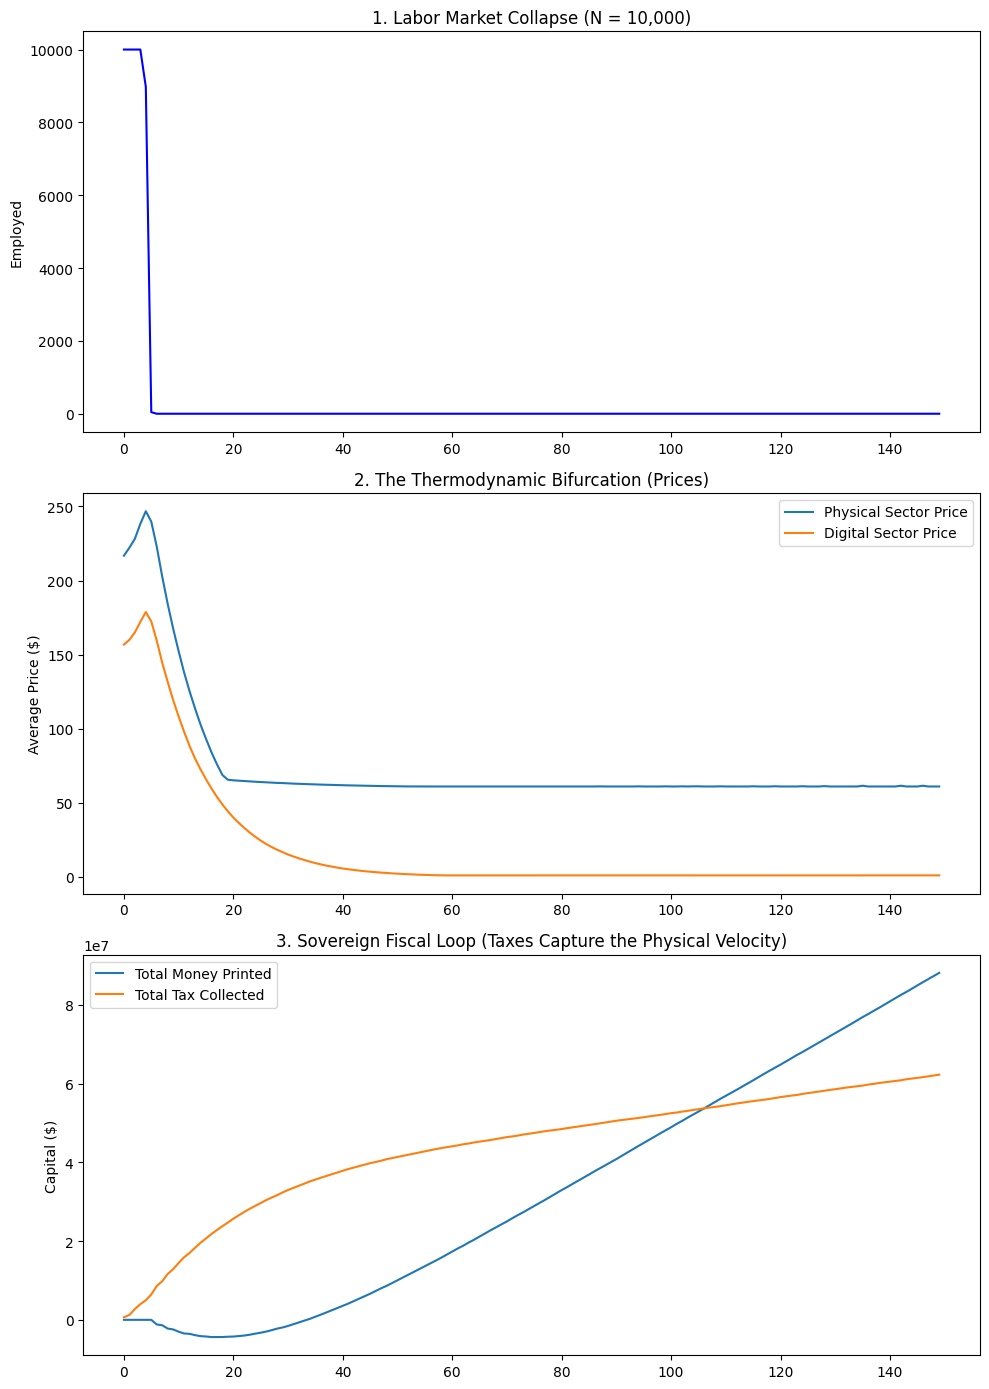

In [9]:
import mesa
import random
import pandas as pd
import matplotlib.pyplot as plt
import time

class CentralBankAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.ubi_active = False
        self.ubi_amount = 100
        self.interest_rate = 1.0
        self.vat_rate = 0.20
        self.reserve_tax_rate = 0.05
        self.tax_collected_this_tick = 0

    def step(self):
        # 1. Wealth/Reserve Tax Phase
        reserve_tax_total = 0
        for a in self.model.firms: # OPTIMIZATION: Scan only firms
            if not a.bankrupt:
                tax = a.cash_reserves * self.reserve_tax_rate
                a.cash_reserves -= tax
                reserve_tax_total += tax

        total_tax_this_tick = reserve_tax_total + self.tax_collected_this_tick
        self.model.total_tax_collected += total_tax_this_tick

        # 2. Employment Monitor
        employed = sum(1 for a in self.model.households if a.employment_status == "Employed")
        employment_rate = employed / self.model.num_households

        # 3. Fiscal Policy (Closed-Loop UBI)
        if employment_rate < 0.5:
            self.ubi_active = True

        if self.ubi_active:
            total_ubi_needed = self.ubi_amount * self.model.num_households
            deficit = total_ubi_needed - total_tax_this_tick
            self.model.total_money_printed += deficit

            for a in self.model.households: # OPTIMIZATION: Scan only households
                a.wealth += self.ubi_amount

        # Reset VAT collector
        self.tax_collected_this_tick = 0

        # 4. Monetary Policy
        if self.model.bankruptcies > self.model.previous_bankruptcies:
            self.interest_rate = max(0.1, self.interest_rate - 0.2)
        self.model.previous_bankruptcies = self.model.bankruptcies


class HouseholdAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.wealth = random.uniform(2000, 5000)
        self.wage = 100
        self.employment_status = "Employed"
        self.employer = None
        self.productivity = random.uniform(0.8, 1.2)
        self.friction_tolerance = 1.0

    def step(self):
        if self.employment_status == "Employed" and self.employer is not None:
            self.wealth += self.wage
        else:
            self.wealth -= 80

        if self.wealth > 0:
            # Households must buy BOTH physical necessities and digital utilities
            self.buy_goods("Physical")
            self.buy_goods("Digital")

    def buy_goods(self, sector):
        # OPTIMIZATION: Massive speedup. We only check the small list of 100 firms.
        active_firms =[f for f in self.model.firms if not f.bankrupt and f.sector == sector and f.sales_this_tick < f.capacity]
        if not active_firms:
            return

        effective_friction = max(0.0, self.friction_tolerance - (self.model.global_ai_score / 100))

        if effective_friction > 0.5:
            chosen_firm = random.choice(active_firms)
        else:
            # Manual min-finding is faster than lambda functions in tight loops
            min_price = float('inf')
            chosen_firm = None
            for f in active_firms:
                if f.price_of_goods < min_price:
                    min_price = f.price_of_goods
                    chosen_firm = f

        # Execute Transaction
        price = chosen_firm.price_of_goods
        if self.wealth >= price:
            self.wealth -= price
            vat = price * self.model.central_bank.vat_rate
            revenue = price - vat

            chosen_firm.cash_reserves += revenue
            self.model.central_bank.tax_collected_this_tick += vat
            chosen_firm.sales_this_tick += 1
            self.model.velocity_of_money += price


class FirmAgent(mesa.Agent):
    def __init__(self, model, sector):
        super().__init__(model)
        self.sector = sector
        self.cash_reserves = random.uniform(5000, 10000)
        self.employees =[]
        self.price_of_goods = random.uniform(90, 120)
        self.ai_capability_score = 0
        self.bankrupt = False
        self.base_debt_obligation = 500
        self.capacity = 200 # Scaled up to handle N=10,000 distribution
        self.sales_this_tick = 0

        # THE THERMODYNAMIC FLOOR: Physical goods have hard cost limits. Digital does not.
        self.rho = 60 if sector == "Physical" else 0

    def step(self):
        if self.bankrupt:
            return

        self.capacity = 200 + int(self.ai_capability_score * 50)
        ai_cost = self.model.base_ai_cost / (1 + (self.ai_capability_score * 0.1))

        for emp in list(self.employees):
            if ai_cost < (emp.wage * emp.productivity):
                self.employees.remove(emp)
                emp.employment_status = "Unemployed"
                emp.employer = None
                self.ai_capability_score += 1
                self.model.global_ai_score += 0.5

        # Endogenous Pricing
        if self.sales_this_tick >= self.capacity:
            self.price_of_goods *= 1.05
        elif self.sales_this_tick == 0:
            self.price_of_goods *= 0.90
        else:
            self.price_of_goods *= 0.98

        # Price Floor Calculation using Thermodynamic limit
        floor_price = max(self.rho + 1, ai_cost * 1.1 + self.rho)
        self.price_of_goods = max(self.price_of_goods, floor_price)
        self.sales_this_tick = 0

        # Debt Ledger
        effective_debt = self.base_debt_obligation * self.model.central_bank.interest_rate
        self.cash_reserves -= effective_debt

        if self.cash_reserves < 0:
            self.bankrupt = True
            self.model.bankruptcies += 1
            for emp in self.employees:
                emp.employment_status = "Unemployed"
                emp.employer = None
            self.employees =[]


class MacroEnvironment(mesa.Model):
    def __init__(self, num_households, num_firms):
        super().__init__()
        self.num_households = num_households
        self.num_firms = num_firms
        self.global_ai_score = 0
        self.base_ai_cost = 150
        self.velocity_of_money = 0
        self.bankruptcies = 0
        self.previous_bankruptcies = 0
        self.total_money_printed = 0
        self.total_tax_collected = 0
        self.central_bank = CentralBankAgent(self)

        # OPTIMIZATION: Store distinct lists of agents to prevent O(N^2) searches
        self.firms =[]
        for i in range(self.num_firms):
            sector = "Physical" if i % 2 == 0 else "Digital"
            f = FirmAgent(self, sector)
            self.firms.append(f)

        self.households =[]
        for _ in range(self.num_households):
            h = HouseholdAgent(self)
            employer = random.choice(self.firms)
            h.employer = employer
            employer.employees.append(h)
            self.households.append(h)

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Employed Households": lambda m: sum(1 for a in m.households if a.employment_status == "Employed"),
                "Total Money Printed": "total_money_printed",
                "Total Tax Collected": "total_tax_collected",
                "Physical Sector Price": lambda m: sum(f.price_of_goods for f in m.firms if not f.bankrupt and f.sector == "Physical") / max(1, sum(1 for f in m.firms if not f.bankrupt and f.sector == "Physical")),
                "Digital Sector Price": lambda m: sum(f.price_of_goods for f in m.firms if not f.bankrupt and f.sector == "Digital") / max(1, sum(1 for f in m.firms if not f.bankrupt and f.sector == "Digital"))
            }
        )

    def step(self):
        self.velocity_of_money = 0
        self.base_ai_cost *= 0.95
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)


# ==========================================
# RUNNING THE SIMULATION (N=10,000 | M=100)
# ==========================================
if __name__ == "__main__":
    start_time = time.time()
    print("Running optimized simulation...")

    # Scale: 10,000 Households, 100 Firms (50 Physical, 50 Digital)
    model = MacroEnvironment(num_households=10000, num_firms=100)

    # Run for 150 ticks
    for i in range(150):
        model.step()

    print(f"Simulation finished in {time.time() - start_time:.2f} seconds.")

    results = model.datacollector.get_model_vars_dataframe()

    # Plotting the Bifurcation
    fig, axes = plt.subplots(3, 1, figsize=(10, 14))

    results["Employed Households"].plot(ax=axes[0], color='blue')
    axes[0].set_title("1. Labor Market Collapse (N = 10,000)")
    axes[0].set_ylabel("Employed")

    results[["Physical Sector Price", "Digital Sector Price"]].plot(ax=axes[1])
    axes[1].set_title("2. The Thermodynamic Bifurcation (Prices)")
    axes[1].set_ylabel("Average Price ($)")

    results[["Total Money Printed", "Total Tax Collected"]].plot(ax=axes[2])
    axes[2].set_title("3. Sovereign Fiscal Loop (Taxes Capture the Physical Velocity)")
    axes[2].set_ylabel("Capital ($)")

    plt.tight_layout()
    plt.show()